# MAG analysis notebook

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from MAG import MicrosoftAcademicGraph
import os
from sparkhpc import sparkjob
import findspark
from matplotlib import pyplot as plt
import seaborn as sns

# set environment variables
os.environ["SPARK_LOCAL_DIRS"] = "/home/laal/MAG/TMP"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-1.8.0.242.b08-0.el7_7.x86_64"
os.environ['SPARK_HOME'] = "/home/laal/MAG/spark-3.0.2-bin-hadoop2.7"

In [2]:
sj = sparkjob.sparkjob(jobid=36613, memory_per_executor=16000)

In [3]:
config_options = {
    "spark.memory.offHeap.enabled": True,
    "spark.memory.offHeap.size":"1g",
    "spark.sql.adaptive.enabled": True,
    "spark.sql.adaptive.coalescePartitions.enabled": True,
    "spark.sql.optimizer.dynamicPartitionPruning.reuseBroadcastOnly": False,
    "spark.shuffle.io.retryWait": "60s",
    "spark.reducer.maxReqsInFlight": 5,
    "spark.yarn.executor.memoryOverhead": "1gb"
}

job = sj.start_spark(extra_conf = config_options)

['NAME STATE JOBID', 'MAG_attribs RUNNING 36609', 'sparkcluster RUNNING 36613', 'askm_classification_job_04 RUNNING 36603', 'roberta_base RUNNING 36611', 'bikenwgrowth RUNNING 36524_60', 'bikenwgrowth RUNNING 36524_61', 'bikenwgrowth RUNNING 36524_59', 'jupyter RUNNING 36614', 'bikenwgrowth RUNNING 36524_53', 'pen RUNNING 36556', 'pen RUNNING 36555', 'pen RUNNING 36554', 'pen RUNNING 36553', 'pen RUNNING 36551', '']


In [4]:
spark = SparkSession.builder.config(conf=job.getConf()).getOrCreate()

In [5]:
mag = MicrosoftAcademicGraph(spark=spark, data_folderpath="/home/laal/MAG/DATA/")

In [6]:
def author_to_field_of_study(mag):
    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    paper_root_field = mag.getDataframe('PaperRootField')

    query = """
    SELECT paa.AuthorId, 
           prf.AncestorId,
           COUNT(*) AS NumPapersInField
    FROM PaperAuthorAffiliations AS paa
    INNER JOIN WosToMag AS wtm ON paa.AuthorId = wtm.MAG 
    INNER JOIN PaperRootField AS prf ON paa.PaperId = prf.PaperId
    WHERE prf.fieldRank = 1
    GROUP BY paa.AuthorId, 
             prf.AncestorId
    ORDER BY COUNT(*) DESC
    LIMIT 1000
    """
    author_to_field = mag.query_sql(query)
    return author_to_field

In [52]:
def gender_per_discipline_per_year(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    paper_root_field = mag.getDataframe('PaperRootField')
    author_country = mag.getDataframe('AuthorCountry')
    papers = mag.getDataframe('Papers')
    
    query = """
    SELECT 
    YEAR(p.Date), prf.AncestorId, wtm.Gender, COUNT(DISTINCT(paa.PaperId)) as Authorships
    FROM PaperAuthorAffiliations paa 
    INNER JOIN WosToMag wtm ON paa.AuthorId = wtm.MAG
    INNER JOIN Papers p ON paa.PaperId = p.PaperId
    INNER JOIN PaperRootField prf ON paa.PaperId = prf.PaperId
    WHERE prf.fieldRank = 1 AND wtm.Gender IN (0, 1) AND prf.fieldRank = 1 
    GROUP BY YEAR(p.Date), wtm.Gender, prf.AncestorId
    """
    gender_per_discipline = mag.query_sql(query)
    return gender_per_discipline

In [53]:
gender_per_discipline = gender_per_discipline_per_year(mag)
gender_per_discipline_df = gender_per_discipline.toPandas()

In [54]:
filtered = gender_per_discipline_df.sort_values(by=['AncestorId', 'year(Date)'])
filtered = filtered[(filtered['year(Date)'] > 1950) & (filtered['year(Date)'] < 2021)]

In [59]:
ids = [
41008148,
121332964,
71924100,
144024400,
192562407,
127413603,
17744445,
39432304,
185592680,
127313418,
95457728,
15744967,
86803240,
205649164,
142362112,
33923547,
138885662,
144133560,
162324750]

names = [
"Computer science",
"Physics",
"Medicine",
"Sociology",
"Materials science",
"Engineering",
"Political science",
"Environmental science",
"Chemistry",
"Geology",
"History",
"Psychology",
"Biology",
"Geography",
"Art",
"Mathematics",
"Philosophy",
"Business",
"Economics",
]

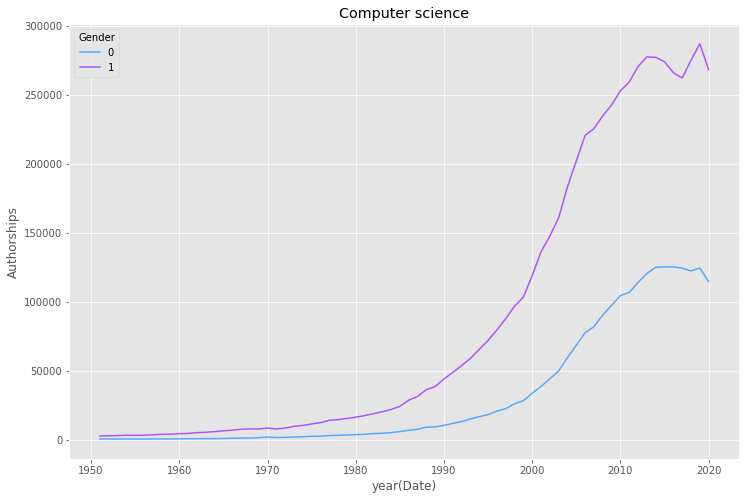

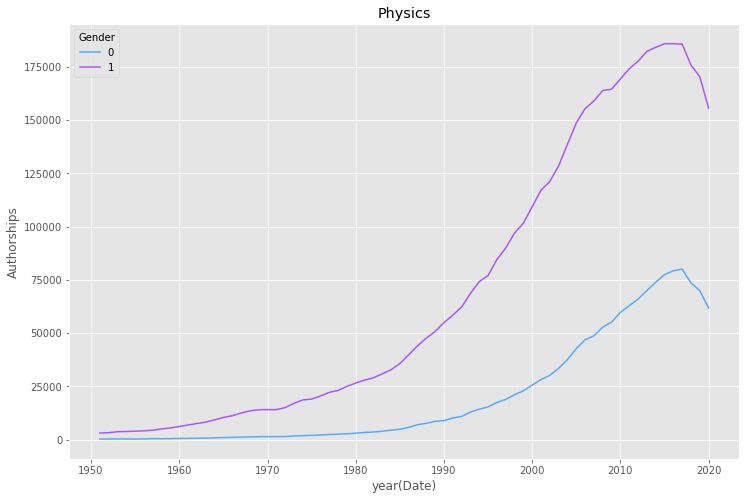

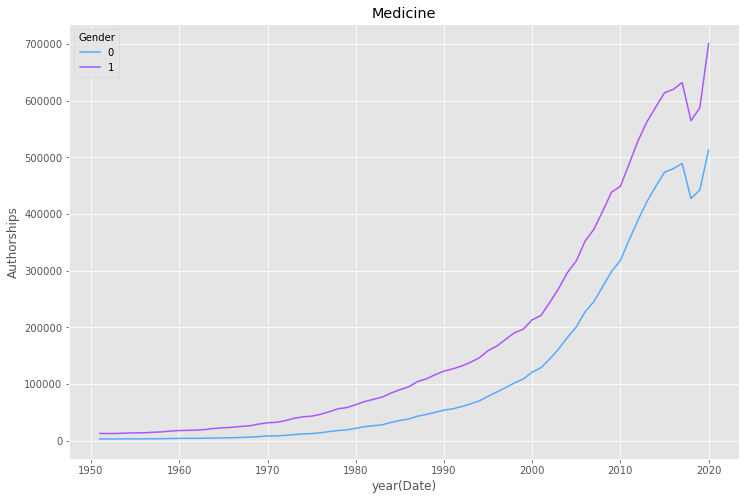

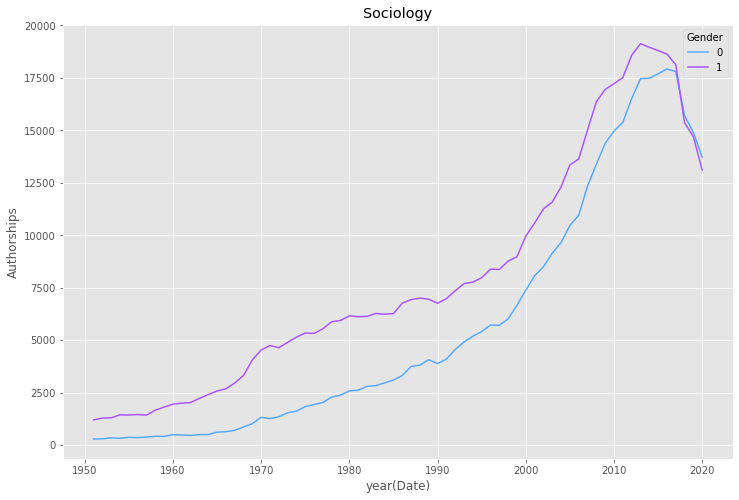

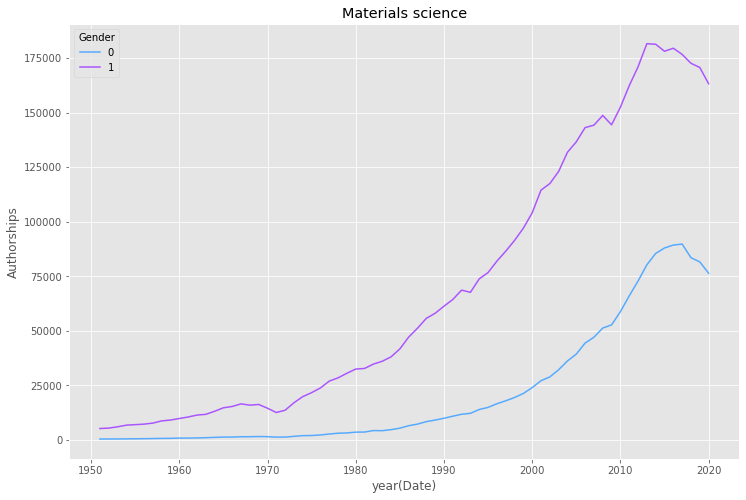

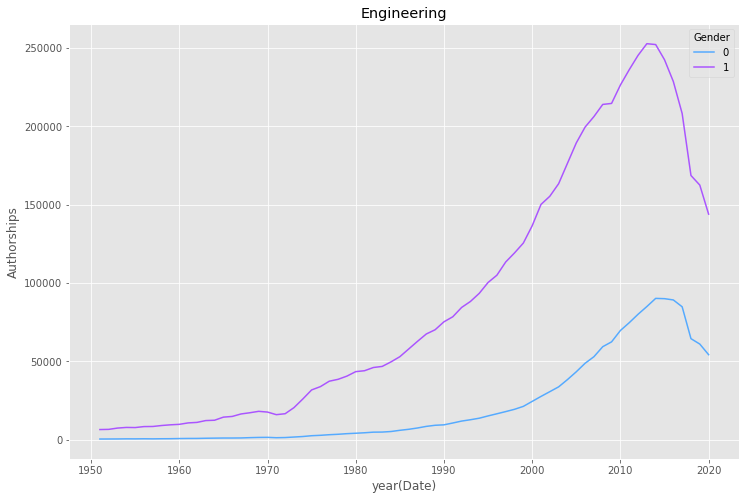

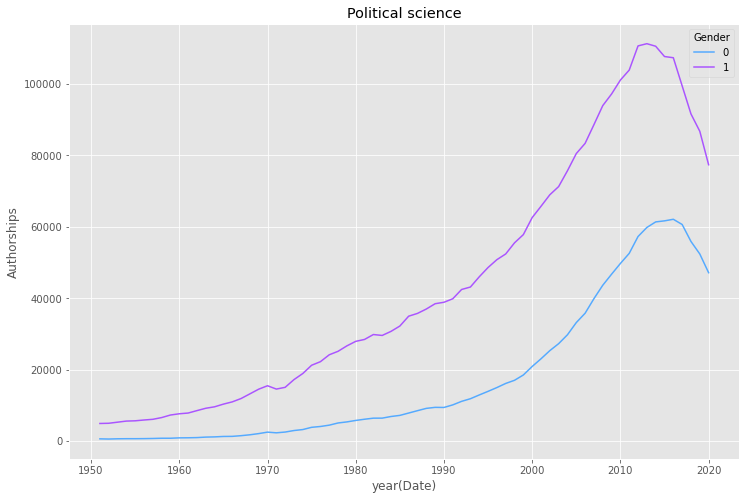

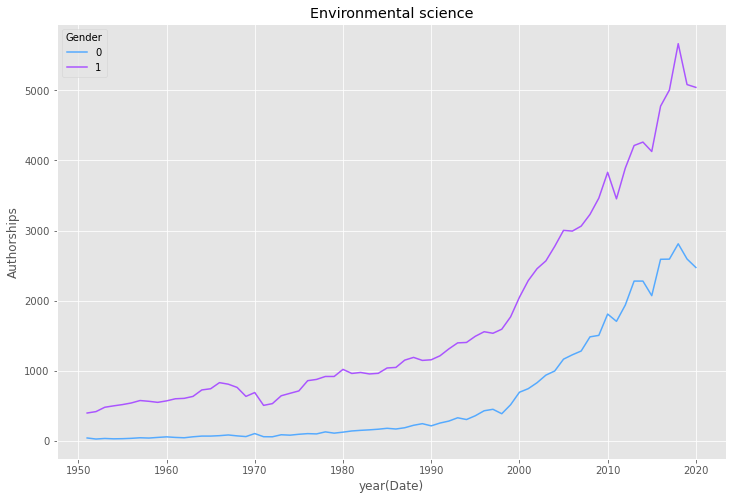

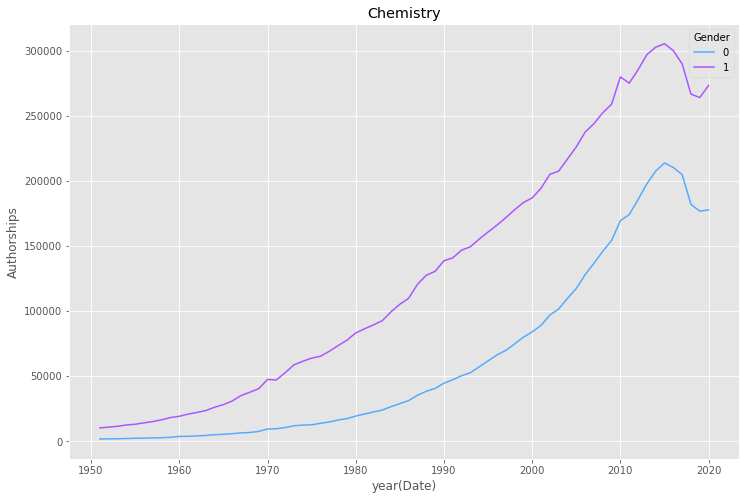

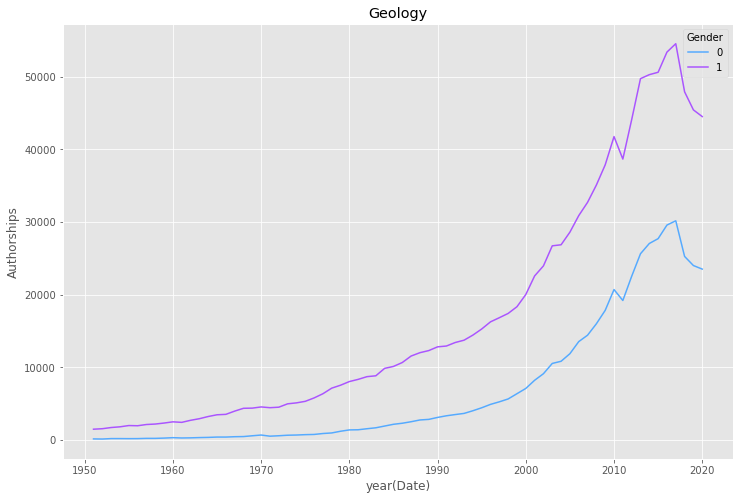

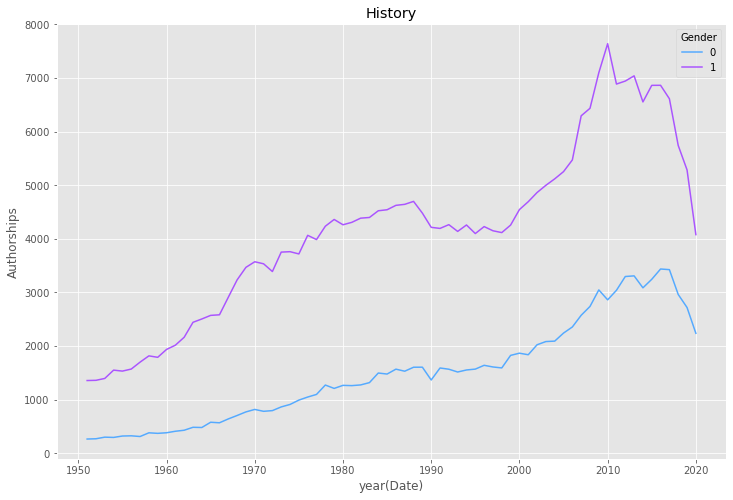

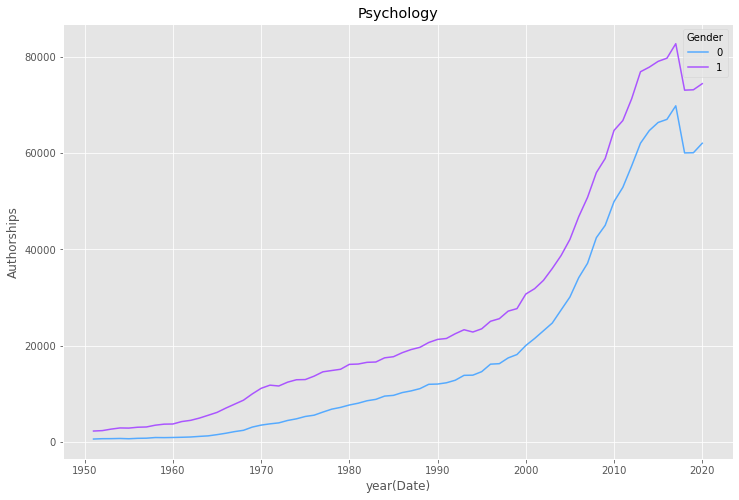

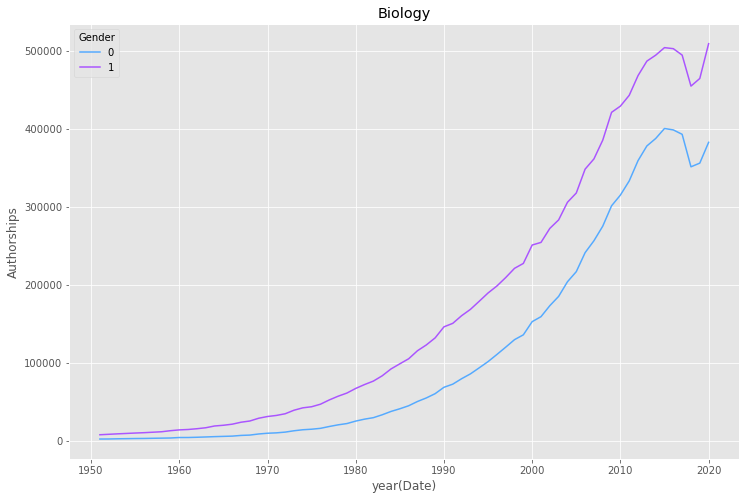

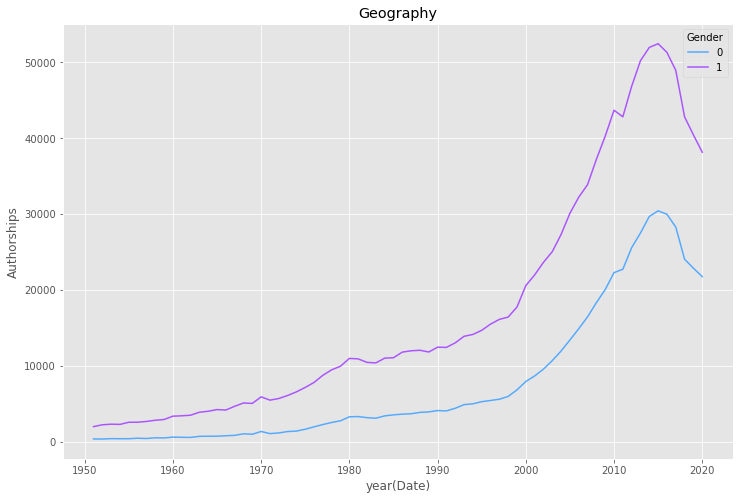

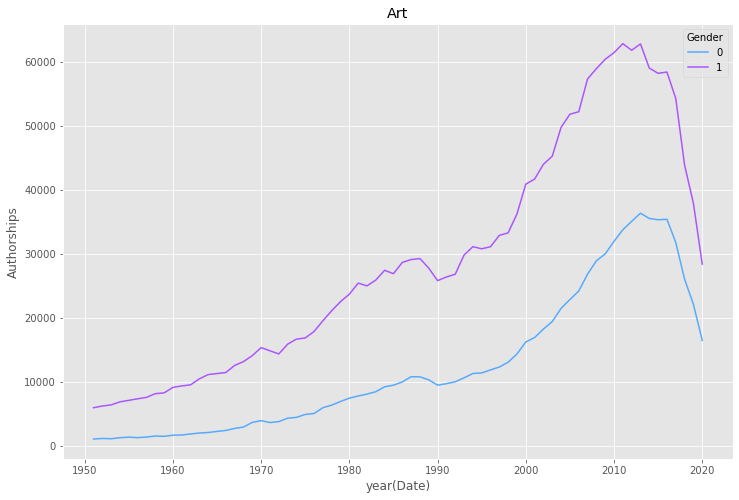

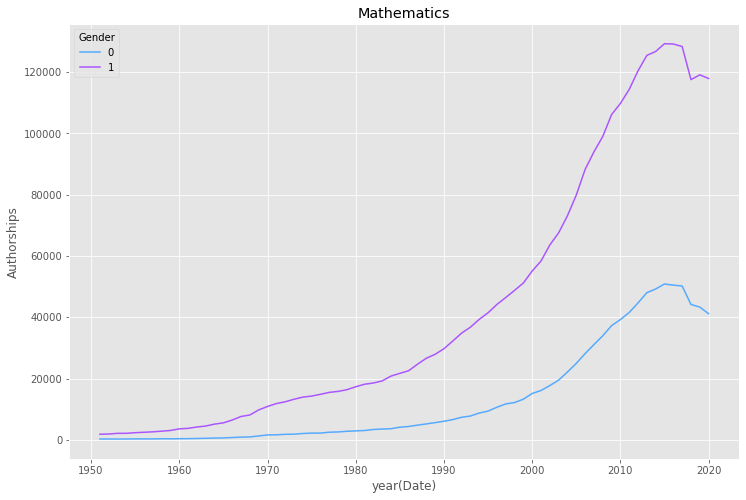

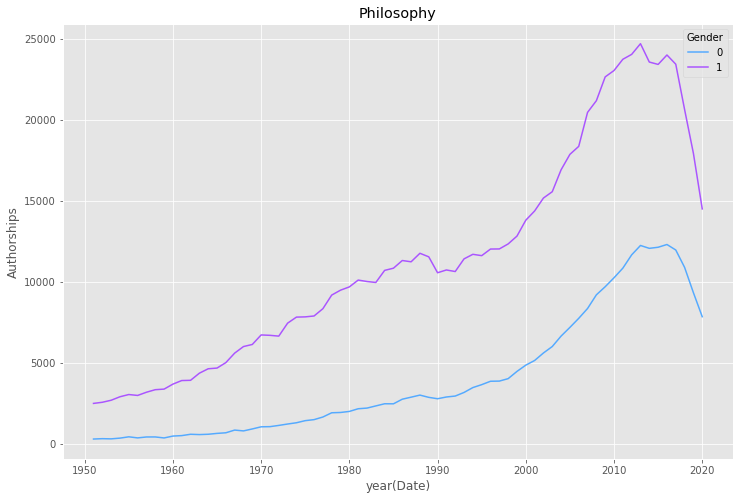

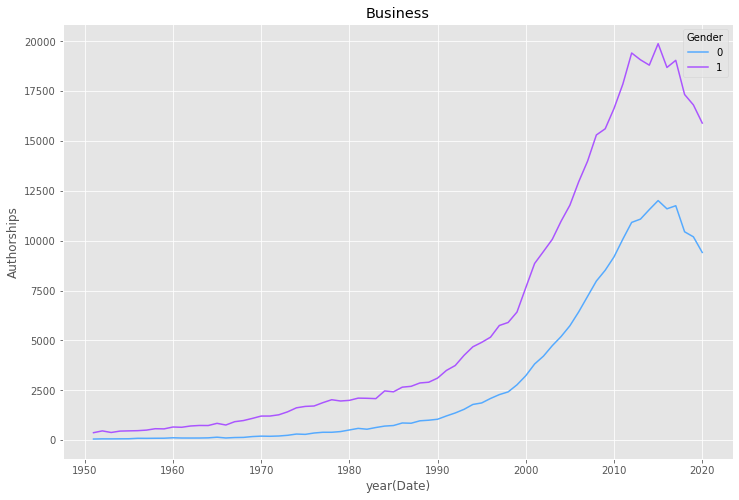

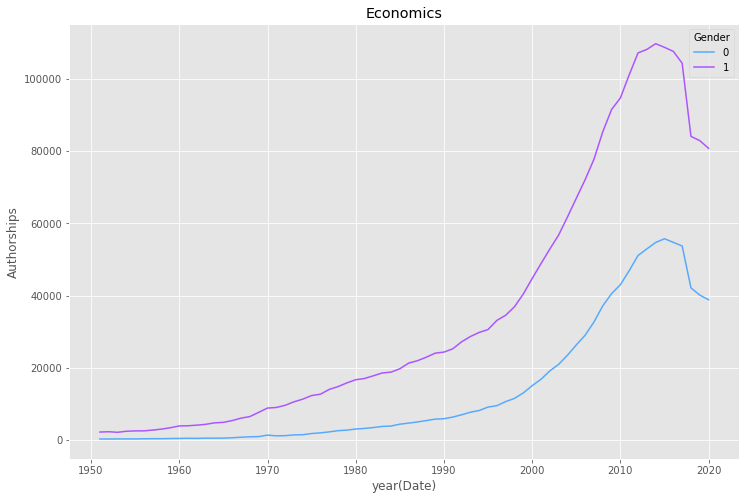

In [61]:
for i in range(len(names)):
    
    fig, ax = plt.subplots(figsize=(12,8))

    sns.lineplot(data=filtered[filtered.AncestorId==ids[i]], 
                 x='year(Date)', y='Authorships', hue='Gender', palette='cool').set_title(names[i])

In [62]:
gender_per_discipline_df.to_csv("MAG_FILES/AuthorshipsPerGenderAndField.csv", index=False)

In [6]:
def gender_per_country_per_year(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    paper_root_field = mag.getDataframe('PaperRootField')
    author_country = mag.getDataframe('AuthorCountry')
    papers = mag.getDataframe('Papers')
    
    query = """
    SELECT 
    YEAR(p.Date), ac.CountryCode, wtm.Gender, COUNT(DISTINCT(paa.PaperId)) as Authorships
    FROM PaperAuthorAffiliations paa 
    INNER JOIN WosToMag wtm ON paa.AuthorId = wtm.MAG
    INNER JOIN Papers p ON paa.PaperId = p.PaperId
    INNER JOIN AuthorCountry ac ON paa.AuthorId = ac.AuthorId
    WHERE ac.countryRank = 1 AND wtm.Gender IN (0, 1)
    GROUP BY YEAR(p.Date), wtm.Gender, ac.CountryCode
    """
    gender_per_discipline = mag.query_sql(query)
    return gender_per_discipline

In [7]:
gender_country_per_year = gender_per_country_per_year(mag)

In [8]:
gender_country_per_year_df = gender_country_per_year.toPandas()

In [9]:
def author_papers_per_year(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    paper_root_field = mag.getDataframe('PaperRootField')
    # author_country = mag.getDataframe('AuthorCountry')
    papers = mag.getDataframe('Papers')
    
    query = """
    SELECT 
    YEAR(p.Date), paa.AuthorId, COUNT(DISTINCT(paa.PaperId)) as NumPapers
    FROM PaperAuthorAffiliations paa 
    INNER JOIN WosToMag wtm ON paa.AuthorId = wtm.MAG
    INNER JOIN Papers p ON paa.PaperId = p.PaperId
    WHERE wtm.Gender IN (0, 1)
    GROUP BY YEAR(p.Date), paa.AuthorId
    """
    pubs_per_year = mag.query_sql(query)
    return pubs_per_year

In [10]:
pubs_per_year = author_papers_per_year(mag)

In [11]:
pubs_per_year.show(35)

+----------+----------+---------+
|year(Date)|  AuthorId|NumPapers|
+----------+----------+---------+
|      2014|2161718200|        3|
|      2014|2489611286|        1|
|      2007|2705495189|        1|
|      1993|2585487612|        7|
|      1993|2056450520|        9|
|      2006|2060097429|        3|
|      2003|2009447725|        1|
|      1998|2134418757|        1|
|      2010|1672876278|        1|
|      1996|2228693780|        4|
|      1989|2700928155|        1|
|      2006|1794687287|       10|
|      2000|2076266424|       26|
|      2008|2156282726|        4|
|      2015|1889410922|       10|
|      2009|2319855747|        5|
|      2000|2109192206|        3|
|      1998|2160973584|        6|
|      1990|2130793380|        2|
|      2013|2158572959|        2|
|      2012|1039421866|        4|
|      1998|2630127522|        1|
|      2009|2001100636|        4|
|      1991|2226204700|        3|
|      1992|2513438065|        5|
|      2008|2121420673|        1|
|      2014|24

In [12]:
pubs_per_year.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/PapersPerAuthorPerYear.txt")

In [6]:
def authors_per_paper(mag):
    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors = mag.getDataframe('WosToMag')
    
    query = """
        SELECT PaperId, 
        COUNT(DISTINCT(AuthorId)) as NumAuthors, 
        (1 / COUNT(DISTINCT(AuthorId))) as Weight,
        COUNT(DISTINCT(wtm.MAG)) as NumMagGendered
        FROM PaperAuthorAffiliations paa
        LEFT JOIN WosToMag AS wtm ON paa.AuthorId = wtm.MAG  
        WHERE wtm.Gender is null or wtm.Gender in (0, 1)
        GROUP BY PaperId
    """
    
    author_paper_stats = mag.query_sql(query)
    return author_paper_stats

In [7]:
author_paper_stats = authors_per_paper(mag)

In [8]:
author_paper_stats.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/AuthorsPerPaper.txt")

In [6]:
def get_weighted_citations(mag):

    author_affiliations = mag.getDataframe('PaperAuthorAffiliations')
    authors_per_paper = mag.getDataframe('AuthorsPerPaper')  
    authors = mag.getDataframe('WosToMag')
    paper_references = mag.getDataframe('PaperReferences')
    # citations = mag.getDataframe('Citations')
    
    query = """
        SELECT 
          paa1.AuthorId AS CitingAuthorId, 
          pr.PaperId AS CitingPaperId, 
          wtm1.Gender as CitingAuthorGender,
          paa2.AuthorId as CitedAuthorId,
          pr.PaperReferenceId as CitedPaperId,
          wtm2.Gender as CitedAuthorGender,
          (app1.Weight * app2.Weight) as CitationWeight
        FROM PaperAuthorAffiliations AS paa1 
        INNER JOIN PaperReferences pr ON paa1.PaperId = pr.PaperId
        INNER JOIN PaperAuthorAffiliations AS paa2 ON pr.PaperReferenceId = paa2.PaperId 
        INNER JOIN WosToMag AS wtm1 ON paa1.AuthorId = wtm1.MAG 
        INNER JOIN WosToMag AS wtm2 ON paa2.AuthorId = wtm2.MAG 
        INNER JOIN AuthorsPerPaper AS app1 ON paa1.PaperId = app1.PaperId 
        INNER JOIN AuthorsPerPaper AS app2 ON pr.PaperReferenceId = app2.PaperId 
        WHERE wtm1.Gender IN (0, 1) AND wtm2.Gender IN (0, 1)
    """    
    
    weighted_citations = mag.query_sql(query)
    return weighted_citations

In [7]:
weighted_citations = get_weighted_citations(mag)

In [ ]:
weighted_citations.write.option("sep", "\t").option("encoding", "UTF-8")\
.csv("/home/laal/MAG/DATA/WeightedCitations.txt")

In [11]:
author_to_field.show(20)

+----------+----------+----------------+
|  AuthorId|AncestorId|NumPapersInField|
+----------+----------+----------------+
|2310082373| 121332964|            4585|
|2205515583| 121332964|            4448|
|2061787601| 121332964|            4369|
|2759530663| 121332964|            4312|
| 426350050| 121332964|            4144|
|2058546385| 121332964|            4084|
|1796911943| 121332964|            4034|
|2107027955| 121332964|            4029|
|1997479564| 121332964|            4010|
|2145238930| 121332964|            3969|
|2567620095| 121332964|            3945|
|2063723168| 121332964|            3940|
|2077334193| 121332964|            3878|
|2119358905| 121332964|            3845|
|2626143265| 121332964|            3822|
|2055011421| 121332964|            3822|
|2315388596| 121332964|            3816|
|2098153449| 121332964|            3808|
|2094520724| 121332964|            3801|
|2153029437| 121332964|            3790|
+----------+----------+----------------+
only showing top